# Embedded ML Lab - Excercise 2 - Quantization (additional experiments)

Until now, we always used a symmetric min/max scale for quantization of the activations, hence a centered zero point.

We will now do two things to squeeze a little bit more accuracy out of the quantization  
* Firstly, we will loosen our assumption of a symmetric range/zero_point
* Secondly, we will consider "cutting away" parts that are not important for the classification choice


In [1]:
from net import CifarNet
import torch

torch.backends.quantized.engine = 'qnnpack'

import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
tf = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testloader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('data/', train=False, download=True, transform=tf), shuffle=False, batch_size=32)

import time
import nbimporter 

from exercise_21 import net_time
from exercise_21 import net_acc
from exercise_21 import fuse_conv_bn_weights
from exercise_21 import QCifarNet, QConv2dReLU, QLinear
from exercise_21 import tensor_scale

Files already downloaded and verified


We introduce two changed Modules (`QConv2dreluNSym`, `QLinerNSym`) that besides a scale (like in the last exercise) also have an adjustable zero_point that can be also set through the state_dict.

We use these two Modules in a new Classifier called `QCifarNetSym`  

In [2]:
from torch.nn.quantized.modules.utils import _pair_from_first
import torch.nn as nn
import torch.nn.functional as F

#Both classes now also have a state-dict entry for the zero_point
class QConv2dReLUNSym(QConv2dReLU):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(QConv2dReLUNSym, self).__init__(in_channels, out_channels, kernel_size, stride, padding)
        self.register_buffer('zero_point', torch.tensor(64))

    def forward(self, x):
        return torch.ops.quantized.conv2d_relu(x, self._prepack, self.scale, self.zero_point)

    
class QLinearNSym(QLinear):
    def __init__(self, in_features, out_features):
        super(QLinearNSym, self).__init__(in_features, out_features)
        self.register_buffer('zero_point', torch.tensor(64))
   
    def forward(self, x):
        return torch.ops.quantized.linear(x, self._prepack, self.scale, self.zero_point)
    
    
class QCifarNetNSym(QCifarNet):
    def __init__(self):
        super(QCifarNet, self).__init__()
        
        self.register_buffer("scale", torch.tensor(0.1))

        self.conv1 = QConv2dReLUNSym(3, 16, 3, 1, padding=1)
        self.conv2 = QConv2dReLUNSym(16,16, 3, 1, padding=1)

        self.conv3 = QConv2dReLUNSym(16, 32, 3, 1, padding=1)
        self.conv4 = QConv2dReLUNSym(32, 32, 3, 1, padding=1)

        self.conv5 = QConv2dReLUNSym(32, 64, 3, 1, padding=1)
        self.conv6 = QConv2dReLUNSym(64, 64, 3, 1, padding=1)

        self.fc = QLinearNSym(1024, 10)

Your Task:
   * Copy your class description of `CifarNetCalibration` from the last lab into the next block.
   * Besides the calibration, add execute the function `plot_density` after each operator.
   * Run the calibration batch again (code provided) and inspect the figures. What observation can you make?

In [3]:
import matplotlib.pyplot as plt

def plot_density(x):
    # input tensor x
    x = x.detach()
    plt.hist(x.flatten().numpy(), range=(float(x.min()),float(x.max())), density=True, bins=50)
    plt.title('input probability density function')
    plt.ylabel('likelihood')
    plt.xlabel('values')
    plt.show()

In [4]:
class CifarNetCalibration(CifarNet):
    def __init__(self):
        super(CifarNetCalibration, self).__init__()
        
        #we add a new dict for the corresponding scales
        self.calibration_dict = {}
        
    def forward(self, x):
        
        self.calibration_dict["scale"] = tensor_scale(x)
        plot_density(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        self.calibration_dict["conv1.scale"] = tensor_scale(x)
        plot_density(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        self.calibration_dict["conv2.scale"] = tensor_scale(x)
        plot_density(x)
        
        x = F.max_pool2d(x, 2, stride=2)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        
        self.calibration_dict["conv3.scale"] = tensor_scale(x)
        plot_density(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        
        self.calibration_dict["conv4.scale"] = tensor_scale(x)
        plot_density(x)
        
        x = F.max_pool2d(x, 2, stride=2)

        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        
                
        self.calibration_dict["conv5.scale"] = tensor_scale(x)
        plot_density(x)
        
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        
        self.calibration_dict["conv6.scale"] = tensor_scale(x)
        plot_density(x)
        
        x = F.max_pool2d(x, 2, stride=2)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        
        self.calibration_dict["fc.scale"] = tensor_scale(x)
        plot_density(x)
        
        return x

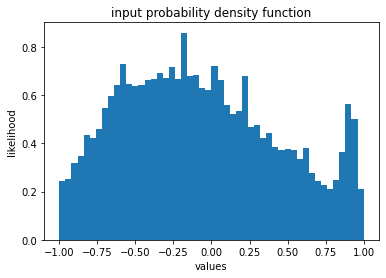

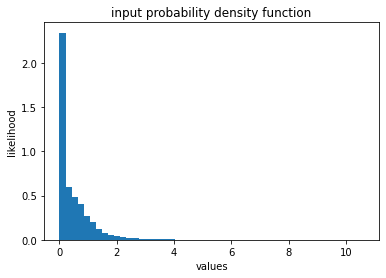

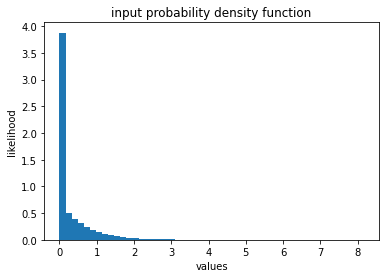

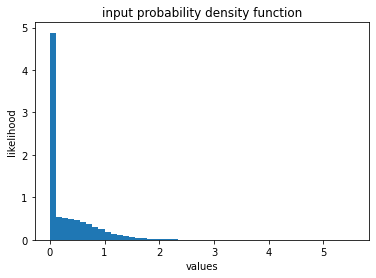

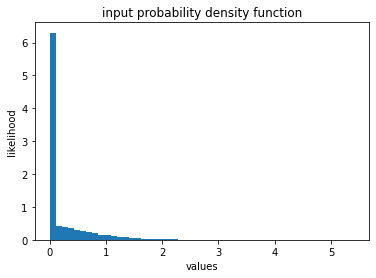

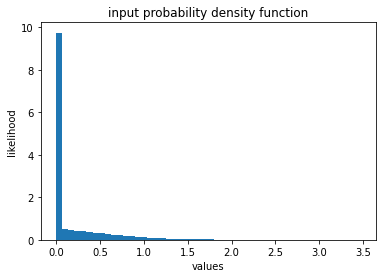

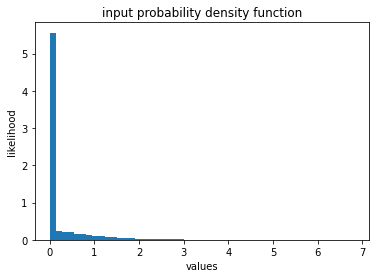

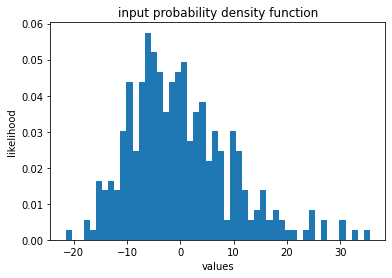

In [5]:
#We run the calibration using a batch from the testdata
net_calib = CifarNetCalibration()
net_calib.load_state_dict(torch.load('state_dict.pt'))
_, (data, _) = next(enumerate(testloader))
net_calib(data)
calibration_dict = net_calib.calibration_dict

Your Task: 
* Copy Your code that sets the quantized state dict after calibration from the last lab. The state dict has now new entries `zero_point` for the fused conv and the fc layer.
* Explore what happens if we change the scale of the conv layer in a way that better suits the plots. Use the provided code to determine the accuracy for each step.
* After that, adjust the scale of the conv layers according to the figures

Your Task:
* After that, play around with scale and zero_point of the fully connected layer. What conclusion can we draw?

In [12]:
import itertools
for scale_factor, zero_point in itertools.product([0.5, 0.75, 1], [0]):
    
    qnet = QCifarNetNSym()
    qsd = qnet.state_dict()

    sd = torch.load('state_dict.pt')
    
    for j in range(6):
        i = j + 1
        w = sd[f"conv{i}.weight"]
        b = sd[f"conv{i}.bias"]
        bw = sd[f"bn{i}.weight"]
        bb = sd[f"bn{i}.bias"]
        rm = sd[f"bn{i}.running_mean"]
        rv = sd[f"bn{i}.running_var"]
    
        res_w, res_b = fuse_conv_bn_weights(w,b,rm,rv,bw,bb)
        res_w_scale = tensor_scale(res_w)
    
        qsd[f"conv{i}.weight"] = torch.quantize_per_tensor(res_w, scale = res_w_scale, zero_point = 0, dtype=torch.qint8)
        qsd[f"conv{i}.bias"] = res_b

    qsd["fc.weight"] = torch.quantize_per_tensor(
        sd["fc.weight"], scale = tensor_scale(sd["fc.weight"]), zero_point = 0, dtype=torch.qint8)

    qsd["fc.bias"] = sd["fc.bias"]


    for key in calibration_dict:
        qsd[key] = torch.tensor(calibration_dict[key])
        
    if scale_factor == 0.5 and zero_point == 0:
        print("ohne änderung")
        print(f"Accuracy quantized: {net_acc(QCifarNetNSym, qsd, testloader, max_counter = 250):.4%}")
    
    for i in range(5):
        qsd[f"conv{i+2}.zero_point"] = torch.tensor(zero_point)

        qsd[f"conv{i+2}.scale"] = scale_factor * qsd[f"conv{i+2}.scale"]
        
        
    qsd["fc.scale"] = 0.5 * qsd["fc.scale"] 
    qsd["fc.zero_point"] = torch.tensor(0)
    
    #We run the accuracy test again to see how much accuracy we loose through quantization
    print("scale_factor", scale_factor, "zero_point", zero_point)
    print(f"Accuracy quantized: {net_acc(QCifarNetNSym, qsd, testloader, max_counter = 250):.4%}")

ohne änderung
Accuracy quantized: 77.5500%
scale_factor 0.5 zero_point 0
Accuracy quantized: 77.6250%
scale_factor 0.75 zero_point 0
Accuracy quantized: 77.4250%
scale_factor 1 zero_point 0
Accuracy quantized: 77.5250%
